**5,6 Тренд-сезонная модель**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import linregress
from math import sqrt
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import durbin_watson
from pandas.plotting import autocorrelation_plot
import scipy.stats
import seaborn as sns
from scipy.stats import t as student
from pandas import Grouper
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/DOM/')

In [ ]:
data=pd.read_csv('USD_RUB.csv')
data.head()

,Date,Price,Open,High,Low,Change %
0,Apr 14 2022,80.9957,79.8675,82.3836,79.8563,1.41%
1,Apr 13 2022,79.8675,79.6800,80.2965,79.4078,0.24%
2,Apr 12 2022,79.6800,79.0650,80.2549,78.6952,0.78%
3,Apr 11 2022,79.0650,76.0800,81.2950,76.0800,3.92%
4,Apr 08 2022,76.0800,75.7500,76.2590,71.3993,0.44%


In [ ]:
data.dtypes

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])

In [ ]:
data = data.iloc[:,0:2].set_index('Date')

In [ ]:
data.head(2)

In [ ]:
series = data.squeeze()
series.head(5)

Date
2022-04-14    80.9957
2022-04-13    79.8675
2022-04-12    79.6800
2022-04-11    79.0650
2022-04-08    76.0800
Name: Price, dtype: float64

In [ ]:
series_month = series.resample('M').mean()

In [ ]:
series_month.tail()

In [ ]:
series_month.plot()

In [ ]:
series_year = series.resample('Y').mean()

In [ ]:
series_year.tail()

In [ ]:
series_year.plot()

In [ ]:
series_month.shape

(248,)

In [ ]:
y = series_month.values
y

In [ ]:
x = np.arange(1,len(y)+1)

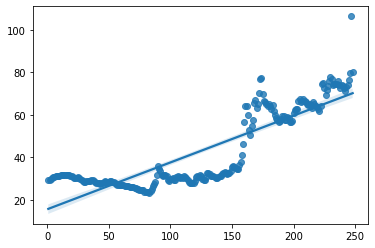

In [ ]:
sns.regplot(x=x,y=y,data=series_month)

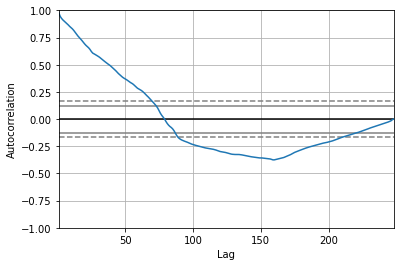

In [ ]:
autocorrelation_plot(y)
plt.show()

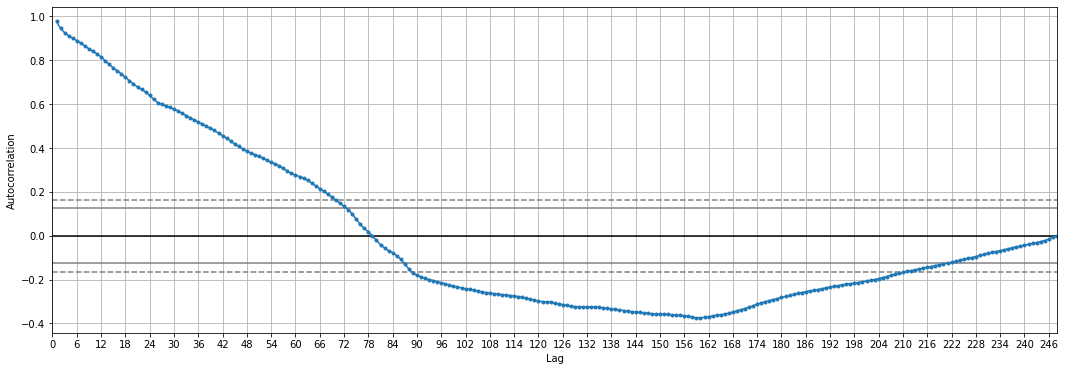

In [ ]:
fig, ax = plt.subplots(figsize = (18, 6)) # лаг сезонности похоже = 12

autocorrelation_plot(y, ax = ax, marker = '.')
ax.xaxis.set_major_locator(plt.MultipleLocator(6))
ax.set_xlim(0, 248)

plt.show()

In [ ]:
series_month = series_month[4:]

In [ ]:
train_size=180

In [ ]:
y_train, y_test = y[0:train_size], y[train_size:len(y)-8]

In [ ]:
len(y_train)

180

In [ ]:
len(y_test)

60

In [ ]:
series_train = series_month[0:train_size]
series_train.head()

**1. Сглаживаем ряд (окно = 12 (месяцы))**

In [ ]:
rolling_mean=series_train.rolling(window=12).mean() # окно=12, т.к. лаг сезонности = 12
rolling_mean.head(20)

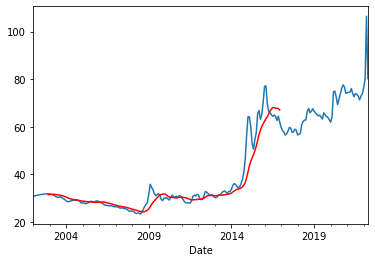

In [ ]:
series_month.plot()
rolling_mean.plot(color='red') # первых нет потому что окно =12, выпадают, а последних нет, т.к. они ушли в тестовый набор
plt.show()

**2. Удаляем тренд и получаем сезонност + случайность**

In [ ]:
X=y_train-rolling_mean # СОДЕРЖИТ СЕЗОННОСТЬ И СЛУЧАЙНОСТЬ
X.head(20)

In [ ]:
series_month.plot()
X.plot(color='red') # первых нет потому что окно =12, выпадают, а последних нет, т.к. они ушли в тестовый набор
plt.show()

**3. ЧИСТИМ ОТ СЛУЧАЙНЫХ ЗНАЧЕНИЙ, очищаем сезонную составляющую**

In [ ]:
groups=X.groupby(Grouper(freq='A'))
groups.mean()

In [ ]:
years=pd.DataFrame()

In [ ]:
for name, group in groups:
#  print(name.year)
#  print(group.values)
  years[name.year]=group.values

In [ ]:
years

,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,NaN,0.164704,0.164004,0.487474,0.055475,-0.271041,-0.108297,-0.155385,-0.405789,0.407786,1.264442,0.412565,0.392719,-3.072601,4.493659
1,NaN,0.157078,-0.040104,0.366418,0.213508,-0.007202,-0.367609,0.055489,-1.722145,-0.004835,1.699363,0.138881,-0.517284,-2.536276,-0.254702
2,NaN,0.245973,-0.128825,-0.046001,0.415546,-0.129711,-0.590680,0.004858,-1.820612,0.779138,1.245092,0.229116,-0.267425,0.896384,0.837012
3,NaN,0.266548,-0.304204,-0.637277,0.457854,-0.279348,-0.279425,0.066423,-0.357863,0.679051,1.806100,-0.567755,-0.524167,9.471456,4.872555
4,NaN,0.284075,-0.734428,-0.488059,0.079967,0.010128,-0.206219,2.901301,-0.371307,0.177793,1.318588,-1.090724,0.101161,16.006719,10.332526
5,NaN,0.184896,-0.931220,-0.447831,0.059308,-0.080345,-0.000747,6.343577,-0.161666,-0.380794,-0.631914,-1.058628,1.473241,14.167369,9.740637
6,NaN,0.065629,-0.798836,-0.732357,-0.128980,-0.168083,-0.597493,4.439775,-0.655557,-0.987733,-1.432810,-0.473233,2.112608,8.303948,1.737538
7,NaN,-0.080437,-0.517571,-0.509958,-0.300622,-0.348480,-0.673722,2.737469,-0.922458,-1.238373,-1.568395,-0.058951,1.404676,-1.483204,-1.519032
8,NaN,-0.271995,-0.130205,-0.289455,-0.666055,-0.229164,-0.482956,0.610381,0.459895,-1.339848,-0.134403,-0.131961,0.115127,-6.079147,-1.878435
9,NaN,-0.583383,0.000602,0.318294,-0.577180,0.017933,-0.702016,-0.481643,1.128230,-1.396288,1.716938,0.785556,-1.094395,-3.931373,-2.758822


--------------------------------------------------------------------------------
**таблица для y_test(проверка_чтобы_в_году_было_по_12_месяцев)**

In [ ]:
dfg = series_month[train_size:len(y)-8]

In [ ]:
dfg

In [ ]:
groups_test=dfg.groupby(Grouper(freq='A'))
groups_test.mean()

Date
2017-12-31    58.310673
2018-12-31    62.789153
2019-12-31    64.675954
2020-12-31    72.288089
2021-12-31    73.700482
Freq: A-DEC, Name: Price, dtype: float64

In [ ]:
years=pd.DataFrame()

In [ ]:
for name, group in groups_test:
#  print(name.year)
#  print(group.values)
  years[name.year]=group.values

In [ ]:
years

,2017,2018,2019,2020,2021
0,59.825852,56.559295,66.543795,61.956055,74.398379
1,58.411747,56.871011,65.851305,64.102300,74.393690
2,57.790468,57.129590,65.100775,74.614948,74.533941
3,56.499175,60.926277,64.550555,75.016773,76.062345
4,56.967400,62.254862,64.912019,72.546879,73.895960
5,58.134624,62.796367,64.052647,69.298860,72.600886
6,59.669338,62.820277,63.244409,71.591795,73.969391
7,59.442370,66.481791,65.837477,73.800143,73.586986
8,57.677767,67.630110,64.931605,76.088477,72.884777
9,57.745205,65.862413,64.325348,77.633136,71.295476


--------------------------------------------------------------------------------

In [ ]:
years['mean']=years.mean(axis=1) # делает столбец в который выводится среднее в строке, т.е. за 3 года
years.shape

(12, 16)

**4. КОРРЕКТИРУЕМ СЕЗОННЫЙ КОЭФФИЦИЕНТ**

In [ ]:
k = years['mean'].mean() # поправочный коэффициент

In [ ]:
k

0.32186338824716326

In [ ]:
years['S'] = years['mean'] - k # скорректированный сезонный коэффициент

In [ ]:
s=years['S']

In [ ]:
sez=pd.concat([s for i in range(15)], ignore_index = True)
sez.index=series_train.index
sez # ряд с сезонными составляющими

Date
2002-01-31   -0.048312
2002-02-28   -0.523251
2002-03-31   -0.202587
2002-04-30    0.725990
2002-05-31    1.701102
                ...   
2016-08-31   -0.684653
2016-09-30   -1.068165
2016-10-31   -0.861688
2016-11-30   -0.920075
2016-12-31   -0.257513
Freq: M, Name: S, Length: 180, dtype: float64

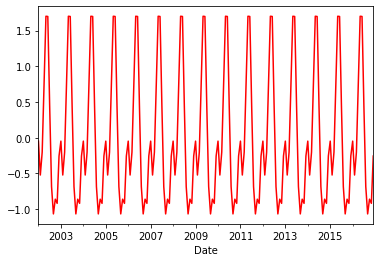

In [ ]:
sez.plot(color='red')
plt.show()

In [ ]:
y_des=y_train - sez # вычлили сезонную составляющую
y_des # это ряд по которому можно строить тренд (т.е. ряд с сезонной составляющей

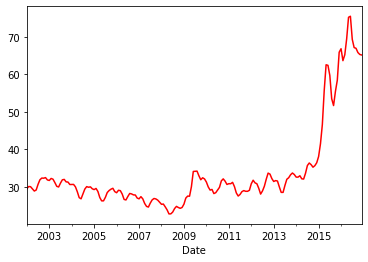

In [ ]:
y_des.plot(color='red')
plt.show()

In [ ]:
x_train = np.arange(1, len(y_des)+1)
x_train

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180])

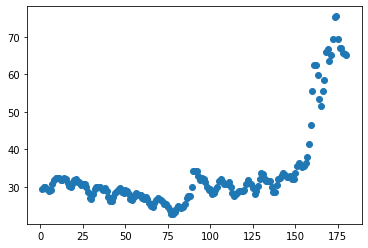

In [ ]:
plt.scatter(x_train,y_des)
plt.show()

In [ ]:
coef=np.polyfit(x_train, y_des, deg=1) # коэффициенты тренда
coef

array([ 0.13667797, 21.42501739])

In [ ]:
t_test = np.arange(train_size+1,len(y)-7)
t_test

In [ ]:
sss = sez=pd.concat([s for i in range(5)], ignore_index = True)

Прогноз:

In [ ]:
y_pred=coef[0]*t_test+coef[1]+sez # s- это сезонная составляющая, а остальные 2(тренд+случайная) уже включены, на них обучали
y_pred

In [ ]:
R2=r2_score(y_test, y_pred)
R2

-5.626863408486599

In [ ]:
MSE=mean_squared_error(y_test, y_pred)
MSE

263.11494652252276

In [ ]:
y_pred=y[len(y_train)-1:len(y)-9]
y_pred

array([64.92097391, 64.37561818, 62.61248571, 64.43285714, 61.92169091,
       59.82585238, 58.41174737, 57.79046818, 56.499175  , 56.9674    ,
       58.13462381, 59.6693381 , 59.44236957, 57.67776667, 57.74520455,
       58.9973    , 58.56682857, 56.559295  , 56.87101053, 57.12959048,
       60.92627727, 62.2548619 , 62.79636667, 62.82027727, 66.4817913 ,
       67.63011   , 65.86241304, 66.55895238, 67.57889048, 66.543795  ,
       65.851305  , 65.100775  , 64.55055455, 64.91201905, 64.05264737,
       63.2444087 , 65.83747727, 64.93160476, 64.32534783, 63.889615  ,
       62.8719    , 61.956055  , 64.1023    , 74.61494762, 75.01677273,
       72.54687895, 69.29886   , 71.59179545, 73.80014286, 76.08847727,
       77.63313636, 76.746795  , 74.06090909, 74.39837895, 74.39369   ,
       74.53394091, 76.06234545, 73.89596   , 72.60088636, 73.96939091])

In [ ]:
MSE=mean_squared_error(y_test, y_pred)
MSE

10.013983818043041

In [ ]:
R2=r2_score(y_test, y_pred) # хороший результат
R2

0.7527897896865889